In [1]:
import pandas as pd

# 读取 OpenFlights 航线数据
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"
cols = ["Airline","Airline_ID","Source_Airport","Source_Airport_ID",
        "Dest_Airport","Dest_Airport_ID","Codeshare","Stops","Equipment"]
routes = pd.read_csv(url, names=cols)

# 看前几行
print(routes.head())


  Airline Airline_ID Source_Airport Source_Airport_ID Dest_Airport  \
0      2B        410            AER              2965          KZN   
1      2B        410            ASF              2966          KZN   
2      2B        410            ASF              2966          MRV   
3      2B        410            CEK              2968          KZN   
4      2B        410            CEK              2968          OVB   

  Dest_Airport_ID Codeshare  Stops Equipment  
0            2990       NaN      0       CR2  
1            2990       NaN      0       CR2  
2            2962       NaN      0       CR2  
3            2990       NaN      0       CR2  
4            4078       NaN      0       CR2  


In [2]:
# 读取机场坐标文件
airports_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
air_cols = ["Airport_ID","Name","City","Country","IATA","ICAO",
            "Latitude","Longitude","Altitude","Timezone","DST",
            "TzDatabaseTimeZone","Type","Source"]
airports = pd.read_csv(airports_url, names=air_cols)

# 开罗机场 IATA 代码为 CAI
routes_cai = routes[(routes["Source_Airport"]=="CAI") | (routes["Dest_Airport"]=="CAI")]

# 合并经纬度
routes_cai = (routes_cai
              .merge(airports[["IATA","Latitude","Longitude"]],
                     left_on="Source_Airport", right_on="IATA")
              .rename(columns={"Latitude":"lat1","Longitude":"lon1"})
              .merge(airports[["IATA","Latitude","Longitude"]],
                     left_on="Dest_Airport", right_on="IATA")
              .rename(columns={"Latitude":"lat2","Longitude":"lon2"}))

print(routes_cai.shape)


(301, 15)


In [17]:
import geopandas as gpd
import geodatasets

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
print(world.head())

  featurecla  scalerank  min_zoom  \
0       Land          1       1.0   
1       Land          1       1.0   
2       Land          1       0.0   
3       Land          1       1.0   
4       Land          1       1.0   

                                            geometry  
0  POLYGON ((-59.57209 -80.04018, -59.86585 -80.5...  
1  POLYGON ((-159.20818 -79.49706, -161.1276 -79....  
2  POLYGON ((-45.15476 -78.04707, -43.92083 -78.4...  
3  POLYGON ((-121.21151 -73.50099, -119.91885 -73...  
4  POLYGON ((-125.55957 -73.48135, -124.03188 -73...  


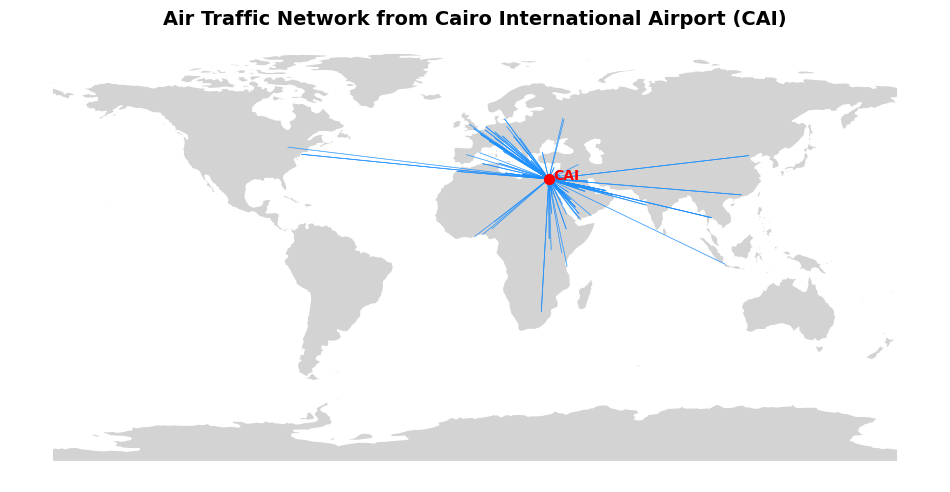

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

# 世界地图底图
world.plot(ax=ax, color="lightgray", edgecolor="white")

# 画出所有从/到 CAI 的航线
for _, row in routes_cai.iterrows():
    ax.plot([row["lon1"], row["lon2"]],
            [row["lat1"], row["lat2"]],
            color="dodgerblue", linewidth=0.5, alpha=0.6)

# 标出开罗机场（CAI）
cairo = airports[airports["IATA"]=="CAI"]
ax.scatter(cairo["Longitude"], cairo["Latitude"], color="red", s=50, zorder=5)
ax.text(cairo["Longitude"].values[0]+2, cairo["Latitude"].values[0],
        "CAI", color="red", fontsize=10, fontweight="bold")

# 美化图像
ax.set_title("Air Traffic Network from Cairo International Airport (CAI)",
             fontsize=14, fontweight="bold")
ax.axis("off")

plt.show()


c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\Jingqi\anaconda3\envs\geospatial\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


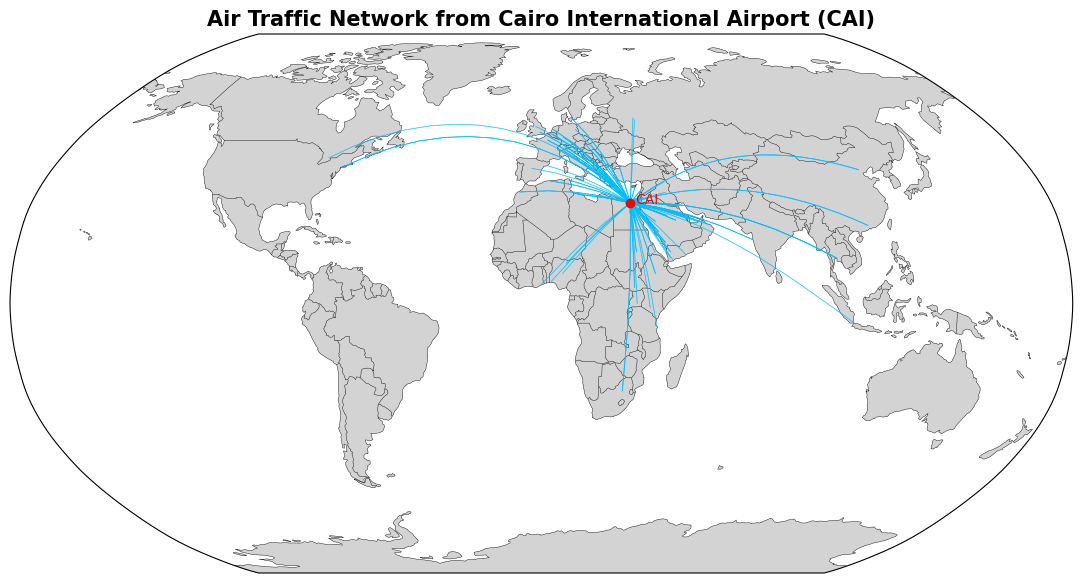

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.set_global()

# 航线
for _, row in routes_cai.iterrows():
    ax.plot([row["lon1"], row["lon2"]],
            [row["lat1"], row["lat2"]],
            color="deepskyblue", linewidth=0.5, alpha=0.6,
            transform=ccrs.Geodetic())  # 用地理曲线

# 开罗机场
ax.plot(31.4065, 30.1219, "ro", markersize=6, transform=ccrs.Geodetic())
ax.text(33, 30, "CAI", color="red", fontsize=10, transform=ccrs.Geodetic())

plt.title("Air Traffic Network from Cairo International Airport (CAI)", fontsize=15, weight="bold")
plt.show()


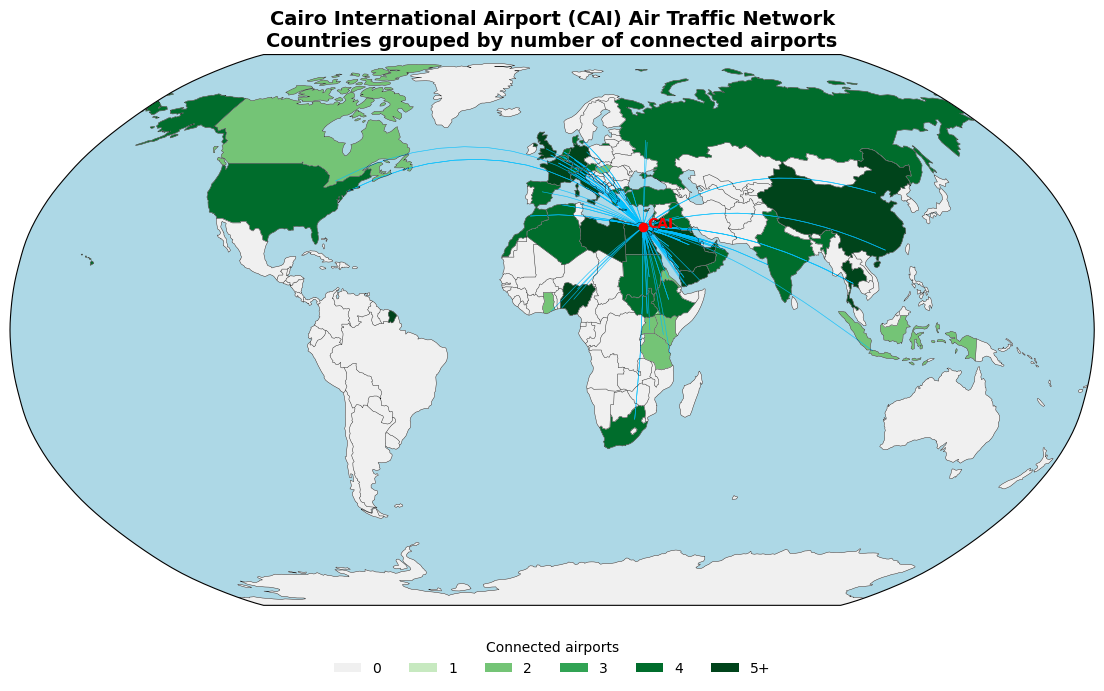

In [28]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

# === 1. 构造机场端点数据 ===
# 取 routes_cai 中所有出发点和目的地（合并）
points = pd.DataFrame({
    "lon": pd.concat([routes_cai["lon1"], routes_cai["lon2"]], ignore_index=True),
    "lat": pd.concat([routes_cai["lat1"], routes_cai["lat2"]], ignore_index=True)
}).dropna()

# 转为 GeoDataFrame
gdf_points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.lon, points.lat), crs="EPSG:4326")

# === 2. 加载国家边界 shapefile（Cartopy 自带）===
shpfilename = shapereader.natural_earth(resolution="110m", category="cultural", name="admin_0_countries")
world = gpd.read_file(shpfilename)[["ADMIN", "geometry"]]  # ADMIN 字段是国家名

# === 3. 做空间连接 ===
joined = gpd.sjoin(gdf_points, world, how="inner", predicate="within")

# === 4. 统计每个国家出现次数（航点数量）===
country_counts = joined["ADMIN"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

# === 5. 合并计数回世界地图，用于上色 ===
world = world.merge(country_counts, left_on="ADMIN", right_on="country", how="left")
world["count"] = world["count"].fillna(0)

# === 6. 绘制地图（带分级 legend）===
import numpy as np
from matplotlib.patches import Patch

# 分级：0,1,2,3,4,5+
bins   = [0, 1, 2, 3, 4, 5, np.inf]
labels = ["0", "1", "2", "3", "4", "5+"]

world["count_bin"] = pd.cut(world["count"].astype(float),
                            bins=bins, labels=labels,
                            include_lowest=True, right=False)

# 每档颜色
colors    = ["#f0f0f0", "#c7e9c0", "#74c476", "#31a354", "#006d2c", "#00441b"]
color_map = dict(zip(labels, colors))
world["color"] = world["count_bin"].map(color_map).fillna("#f0f0f0")

fig = plt.figure(figsize=(14,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# 国家着色
world.plot(ax=ax, transform=ccrs.PlateCarree(),
           color=world["color"], edgecolor="white", linewidth=0.3, zorder=0)

# 航线
for _, row in routes_cai.iterrows():
    ax.plot([row["lon1"], row["lon2"]],
            [row["lat1"], row["lat2"]],
            color="deepskyblue", linewidth=0.4, alpha=0.6,
            transform=ccrs.Geodetic(), zorder=1)

# CAI
ax.plot(31.4065, 30.1219, "ro", markersize=6, transform=ccrs.PlateCarree(), zorder=2)
ax.text(33, 30, "CAI", color="red", fontsize=10, fontweight="bold", transform=ccrs.PlateCarree())

# Legend：0–5+
legend_elems = [Patch(facecolor=colors[i], edgecolor='none', label=labels[i]) for i in range(len(labels))]
ax.legend(handles=legend_elems, title="Connected airports",
          loc="lower center", bbox_to_anchor=(0.5, -0.15),
          ncol=6, frameon=False)

plt.title("Cairo International Airport (CAI) Air Traffic Network\nCountries grouped by number of connected airports",
          fontsize=14, weight="bold")
plt.tight_layout()
plt.show()
